In [27]:
import sys
sys.path.append("../")  

import numpy as np 
import torch, time
import matplotlib.pyplot as plt
import utility, problem
import random
import net
from scipy.linalg import lstsq

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

# 设置随机种子
set_seed(42)

In [28]:
torch.set_default_dtype(torch.float64)

def u_exact(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return torch.sin(torch.pi*x1)*torch.sin(torch.pi*x2)

def f(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return 2*torch.pi**2*torch.sin(torch.pi*x1)*torch.sin(torch.pi*x2)

In [29]:
def trainnew(model,problem,device,params,optimizer):
    
    problem.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
    int_data = problem.data()["interior_points"]
    bdry_data = problem.data()["boundary_points"]
    int_data.requires_grad = True
    bdry_data.requires_grad = True
    effectiveranks = []
    singular_values = []
    steps = []  
    initialloss = 1
    model.train()
    for step in range(params["trainStep"]):
        u = model(int_data)[1]
        u = u.squeeze(1) if len(u.shape) == 2 else u
        u_second = model(int_data)[0]
        u_bdry = model(bdry_data)[1]
        u_bdry = u_bdry.squeeze(1) if len(u_bdry.shape) == 2 else u_bdry
        model.zero_grad()
        # problem.loss_int(u, int_data)
        # problem.loss_bdry(u_bdry, bdry_data)
        # loss_pde = problem.loss_pde()
        loss_orthogonal = torch.norm(u_second.T @ u_second - torch.eye(params["width"]).to(device).double(), p='fro')
        loss = loss_orthogonal*params["orthogonalpenalty"]
        

        if step%params["writeStep"] == params["writeStep"]-1:
            effectiverank = torch.linalg.matrix_rank(u_second.T@u_second, tol=0.001)
            effectiveranks.append(effectiverank.cpu().numpy())
            print("Loss at Step %s is %s , orthogonal loss %s and rank of matrix %s."%(step+1,loss.detach().cpu().numpy(),loss_orthogonal.detach().cpu().numpy(),effectiverank.cpu().numpy()))


        if step%params["plotStep"] == params["plotStep"]-1:
            tem = lambda x: model(x)[1]
            problem.plot(tem)
        loss.backward()
        optimizer.step()
    print("Final Loss at Step %s is %s with orthogonal loss %s."%(step,loss.detach().cpu().numpy(),loss_orthogonal.detach().cpu().numpy()))
    print("after least squares")
    (A, rhs) = problem.leastsquareproblem(model, int_data, bdry_data)
    w, _, _, _ = lstsq(A, rhs)
    U, s, Vh = torch.linalg.svd(u_second.T@u_second)
    error = A @ w - rhs
    threshold = 1e-3
    effective_rank = (s > threshold).sum()
    print("the error of least square in problem " + str(problem.name)+": ", np.mean(np.abs(error)))
    print("the effective rank of basis in problem %s is %s with threshold %s" % (str(problem.name), effective_rank.detach().cpu().numpy(), threshold))
    perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
    problem.plot(perdict)
    
    return effectiveranks, singular_values

Loss at Step 50 is 40.78275771758087 , orthogonal loss 40.78275771758087 and rank of matrix 29.
Loss at Step 100 is 25.22504355873789 , orthogonal loss 25.22504355873789 and rank of matrix 30.
Loss at Step 150 is 23.435041437630407 , orthogonal loss 23.435041437630407 and rank of matrix 31.
Loss at Step 200 is 22.896109791103058 , orthogonal loss 22.896109791103058 and rank of matrix 32.
the l2 relative error in problem poisson2d:  1.0065128661108165
the maximum pointwise error in problem poisson2d:  1.009760835917018


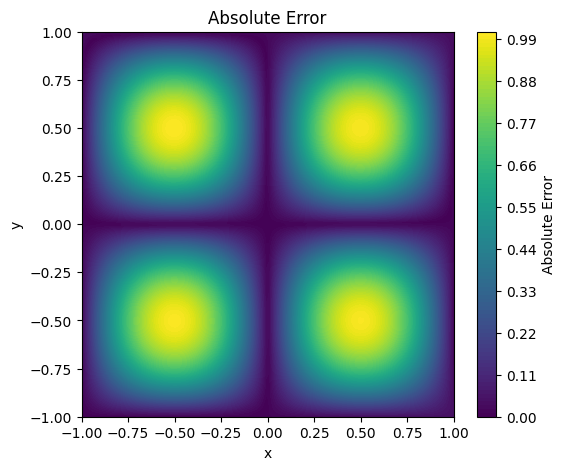

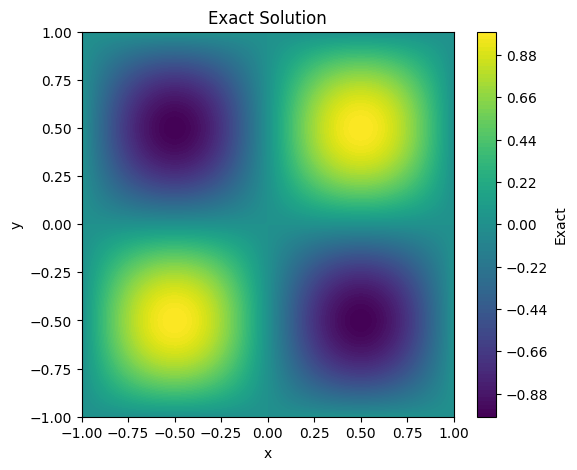

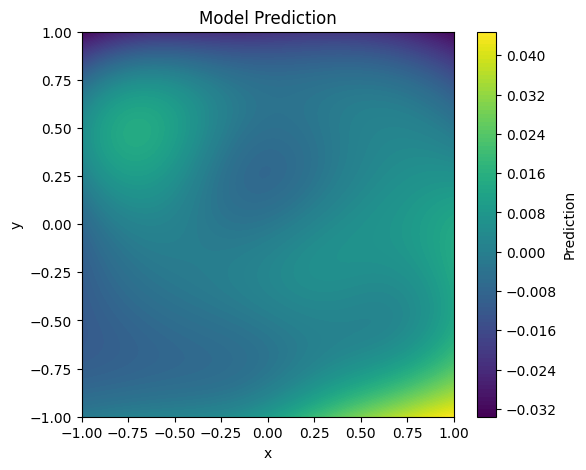

Loss at Step 250 is 22.631171644429823 , orthogonal loss 22.631171644429823 and rank of matrix 33.
Loss at Step 300 is 22.463251871875112 , orthogonal loss 22.463251871875112 and rank of matrix 34.
Loss at Step 350 is 22.343667330149625 , orthogonal loss 22.343667330149625 and rank of matrix 36.
Loss at Step 400 is 22.254599619567315 , orthogonal loss 22.254599619567315 and rank of matrix 36.
the l2 relative error in problem poisson2d:  1.0039204699304352
the maximum pointwise error in problem poisson2d:  1.0068584862470034


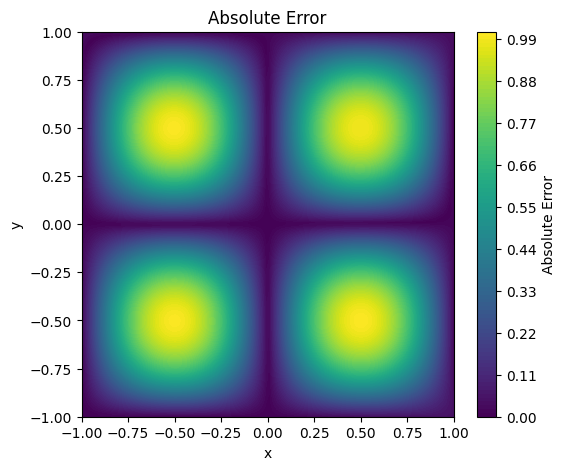

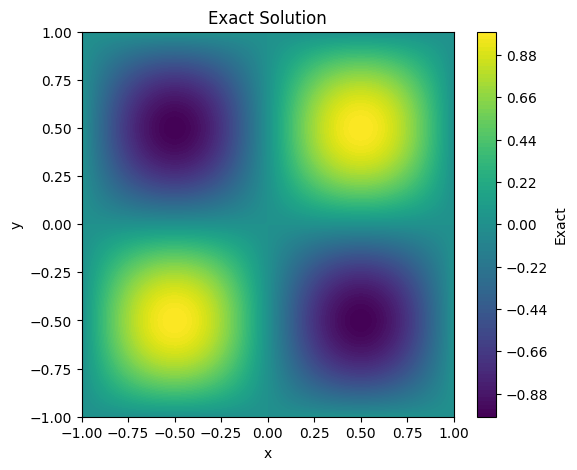

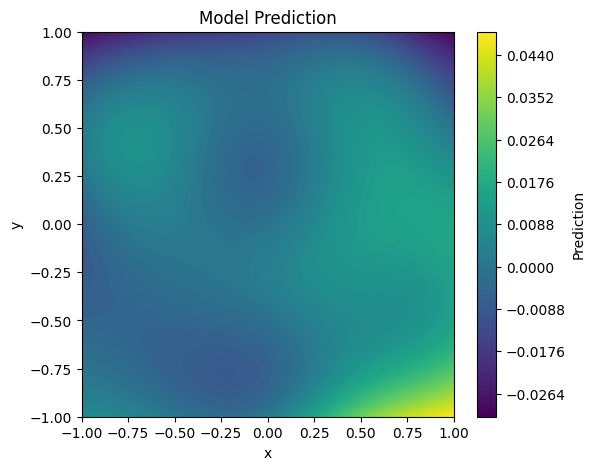

Loss at Step 450 is 22.18503515306171 , orthogonal loss 22.18503515306171 and rank of matrix 36.
Loss at Step 500 is 22.128609565680776 , orthogonal loss 22.128609565680776 and rank of matrix 37.
Loss at Step 550 is 22.08286582762908 , orthogonal loss 22.08286582762908 and rank of matrix 37.
Loss at Step 600 is 22.04559656858253 , orthogonal loss 22.04559656858253 and rank of matrix 38.
the l2 relative error in problem poisson2d:  1.0003964066549664
the maximum pointwise error in problem poisson2d:  1.0070188575948205


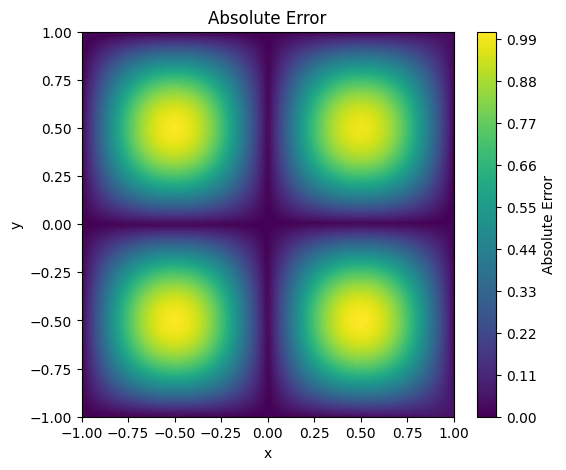

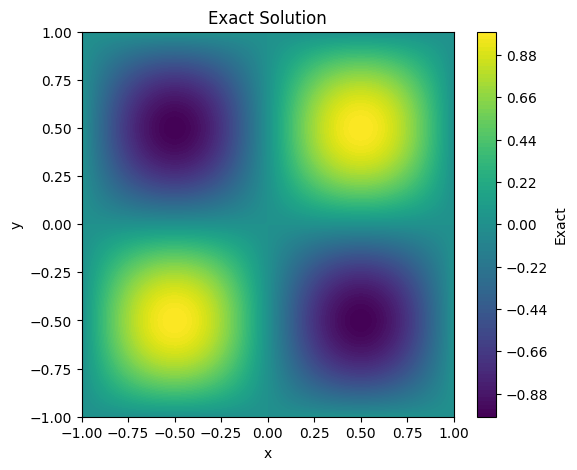

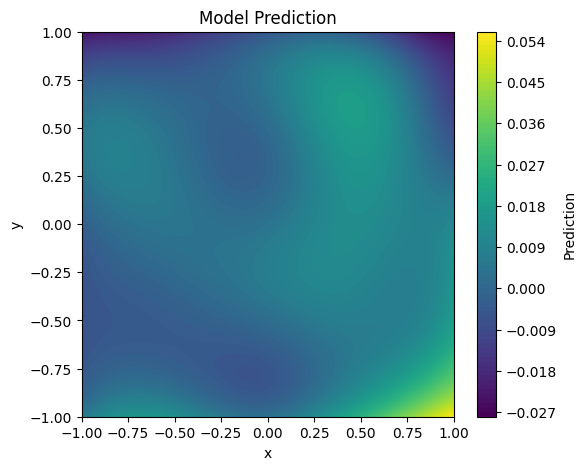

Loss at Step 650 is 22.014436338527616 , orthogonal loss 22.014436338527616 and rank of matrix 40.
Loss at Step 700 is 21.985852473419225 , orthogonal loss 21.985852473419225 and rank of matrix 41.
Loss at Step 750 is 21.957544373921163 , orthogonal loss 21.957544373921163 and rank of matrix 43.
Loss at Step 800 is 21.927369699890242 , orthogonal loss 21.927369699890242 and rank of matrix 44.
the l2 relative error in problem poisson2d:  0.9989215946090733
the maximum pointwise error in problem poisson2d:  1.0050375215699663


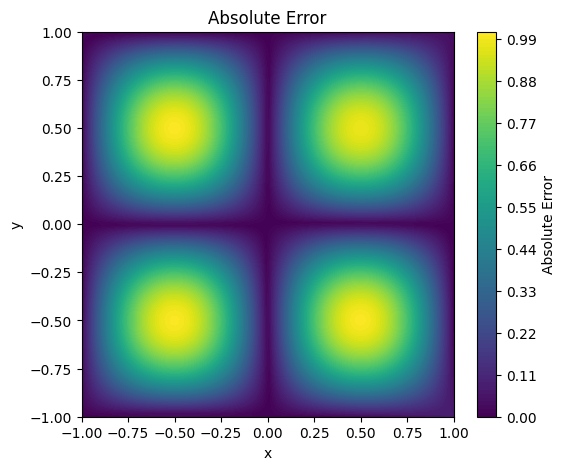

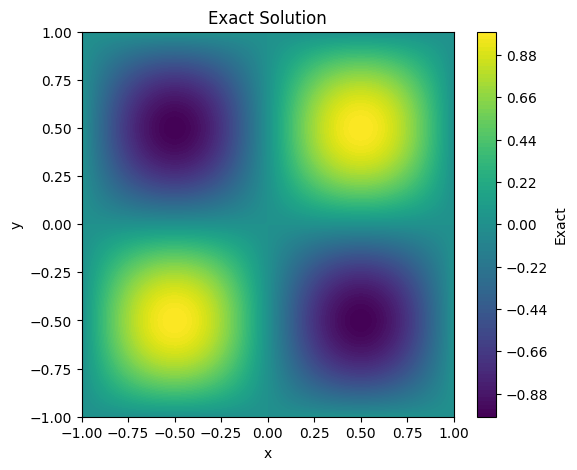

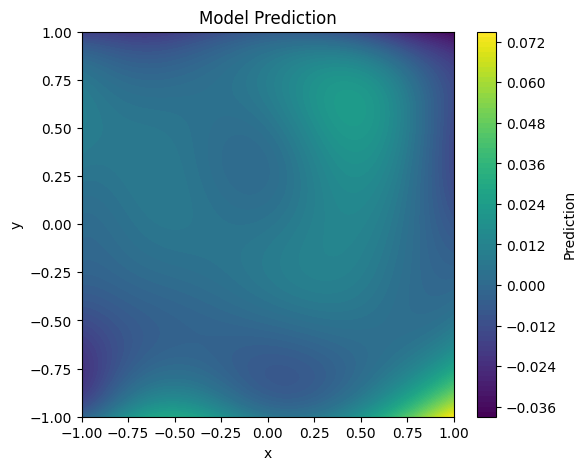

Loss at Step 850 is 21.896189296243666 , orthogonal loss 21.896189296243666 and rank of matrix 46.
Loss at Step 900 is 21.866175751716398 , orthogonal loss 21.866175751716398 and rank of matrix 47.
Loss at Step 950 is 21.837499049972315 , orthogonal loss 21.837499049972315 and rank of matrix 50.
Loss at Step 1000 is 21.808297557564263 , orthogonal loss 21.808297557564263 and rank of matrix 52.
the l2 relative error in problem poisson2d:  0.9973593730601721
the maximum pointwise error in problem poisson2d:  1.00565035427296


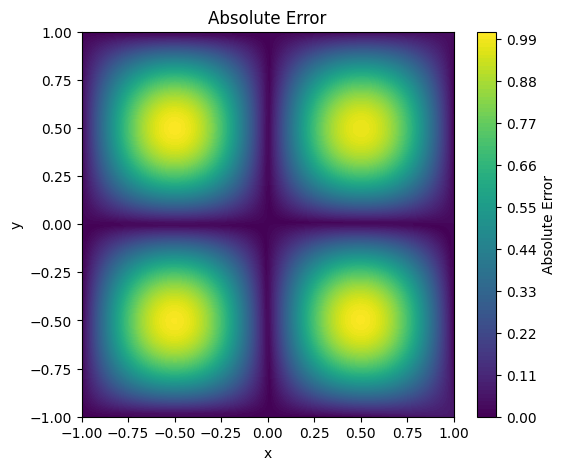

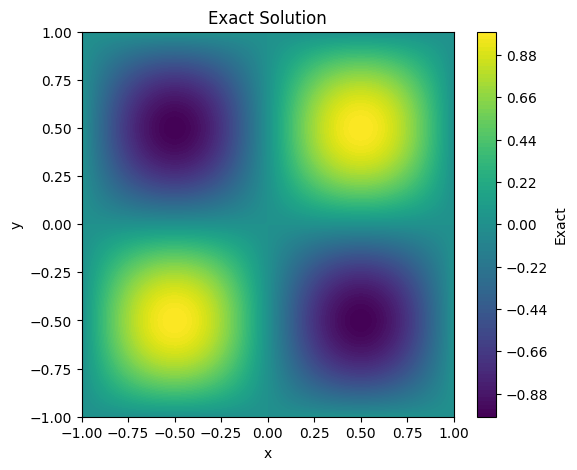

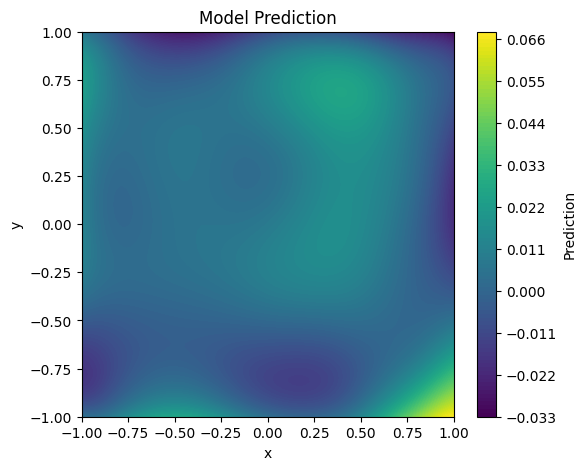

Final Loss at Step 999 is 21.808297557564263 with orthogonal loss 21.808297557564263.
after least squares
the error of least square in problem poisson2d:  6.485197576839957e-06
the effective rank of basis in problem poisson2d is 52 with threshold 0.001
the l2 relative error in problem poisson2d:  1.8375455540802585e-08
the maximum pointwise error in problem poisson2d:  1.7560373332448525e-07


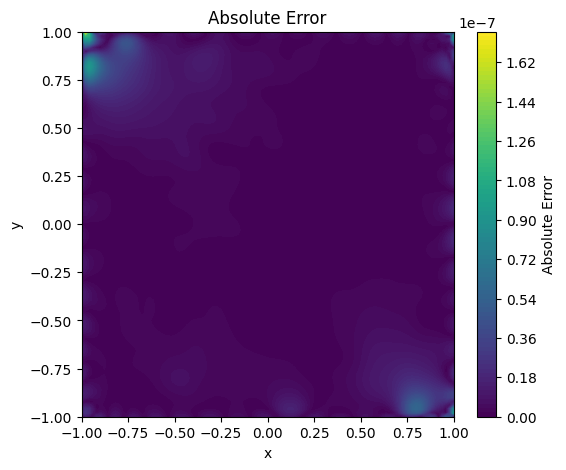

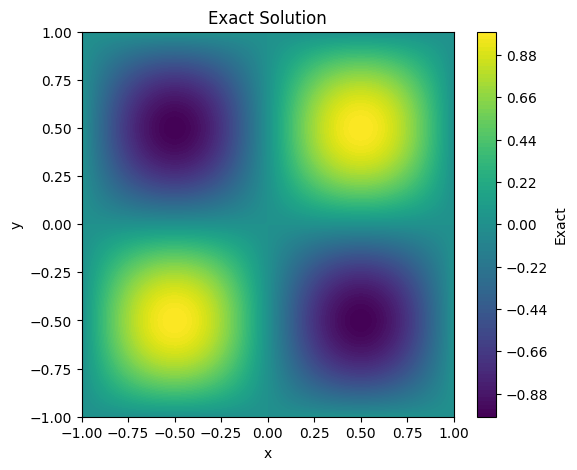

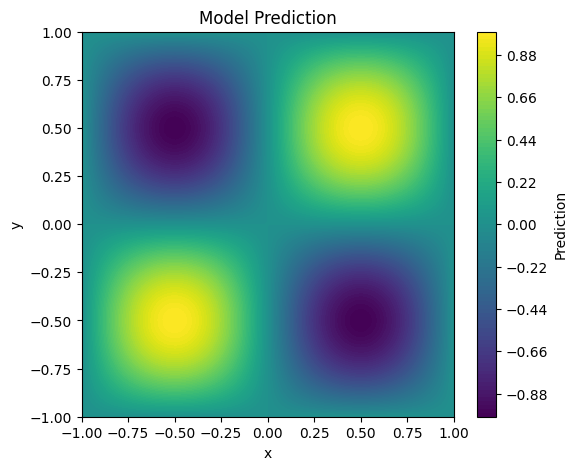

In [30]:
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Pro = problem.PoissonBox(f, u_exact, u_exact, domain_size=1, device=device)
params = {"d": 2, "bodyBatch": 1024, "bdryBatch": 128, "lr": 0.001, "width": 500, "depth": 2, "trainStep": 1000, "plotStep": 200, "writeStep": 50, "decay": 0.0001, "epsilon": 1e-3, "orthogonalpenalty": 1, "beta": 0}
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

startTime = time.time()
rank_orthogonal, sigma_orthogonal = trainnew(model,Pro,device,params,optimizer)

In [31]:
def sample_mu_sigma(K, mu_range, sigma_range):
    """
    采样二维高斯的均值 mu 和协方差矩阵 sigma，强制 sigma 不小于下限
    """
    mu = np.random.uniform(mu_range[0], mu_range[1], size=(K, 2))
    sigma = np.zeros((K, 2, 2))
    for k in range(K):
        sigma_x = np.random.uniform(sigma_range[0], sigma_range[1])
        sigma_y = np.random.uniform(sigma_range[0], sigma_range[1])
        cov = np.random.uniform(-0.2, 0.2) * sigma_x * sigma_y  # 控制相关性
        sigma[k] = np.array([[sigma_x ** 2, cov], [cov, sigma_y ** 2]])
    return mu, sigma


def uj(points, c, mu, sigma):
    """
    计算 u_j(x, y)，输入点为 shape (N, 2)
    
    Parameters:
    points : ndarray of shape (N, 2)
        输入的点集
    c : ndarray
        每个高斯基函数的系数
    mu : ndarray
        每个高斯基函数的中心
    sigma : ndarray
        每个高斯基函数的协方差矩阵
    
    Returns:
    u : ndarray of shape (N,)
        u_j 在每个输入点的函数值
    """
    u = np.zeros(points.shape[0])
    for k in range(len(c)):
        diff = points - mu[k]  # shape: (N, 2)
        inv_sigma = np.linalg.inv(sigma[k])
        exponent = -0.5 * (inv_sigma[0,0] * diff[:,0]**2 + 
                           2 * inv_sigma[0,1] * diff[:,0] * diff[:,1] + 
                           inv_sigma[1,1] * diff[:,1]**2)
        u += c[k] * np.exp(exponent)
    return u

def laplacian_uj(points, c, mu, sigma):
    """
    计算 -Δu_j(x, y)，输入点为 shape (N, 2)
    
    Parameters:
    points : ndarray of shape (N, 2)
        输入的点集
    c : ndarray
        每个高斯基函数的系数
    mu : ndarray
        每个高斯基函数的中心
    sigma : ndarray
        每个高斯基函数的协方差矩阵
    
    Returns:
    lap_u : ndarray of shape (N,)
        -Δu_j 在每个输入点的函数值
    """
    lap_u = np.zeros(points.shape[0])

    for k in range(len(c)):
        inv_sigma = np.linalg.inv(sigma[k])
        diff = points - mu[k]  # shape: (N, 2)

        # 计算高斯核 u
        exponent = -0.5 * (inv_sigma[0, 0] * diff[:, 0]**2 +
                           2 * inv_sigma[0, 1] * diff[:, 0] * diff[:, 1] +
                           inv_sigma[1, 1] * diff[:, 1]**2)
        G = np.exp(exponent)

        # 计算 u_xx 项
        a11 = inv_sigma[0, 0]
        a12 = inv_sigma[0, 1]
        temp_x = a11 * diff[:, 0] + a12 * diff[:, 1]
        u_xx = G * (temp_x**2 - a11)

        # 计算 u_yy 项
        a21 = inv_sigma[1, 0]
        a22 = inv_sigma[1, 1]
        temp_y = a21 * diff[:, 0] + a22 * diff[:, 1]
        u_yy = G * (temp_y**2 - a22)

        lap_u += c[k] * (u_xx + u_yy)

    return -lap_u  # 返回负的拉普拉斯项（右端项）




def generate_random_function(K, mu_range=[-1, 1], sigma_range=[0.2, 0.6]):
    """
    生成完整的随机函数样本，包括 mu, sigma, c
    """
    mu, sigma = sample_mu_sigma(K, mu_range, sigma_range)
    c = np.random.randn(K)
    return mu, sigma, c

###Transfer to Box domain with different right hind side

In [32]:
Pro = problem.PoissonBox(f, u_exact, u_exact, 1, 1, device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "uniform")
body = Pro.data()["interior_points"]
bdry = Pro.data()["boundary_points"]

basis = lambda x: model(x)[0]
u_body = basis(body)
Nb, Mb = u_body.shape[0], u_body.shape[1]
A_body = torch.zeros(Nb, Mb, device=device)
for i in range(Mb):
    laplace = model.laplacian(body, i)  
    A_body[:, i] = (-laplace).detach()
A_bdry = basis(bdry)
A = torch.cat((A_body, A_bdry), dim=0)
A_np = A.cpu().detach().numpy()

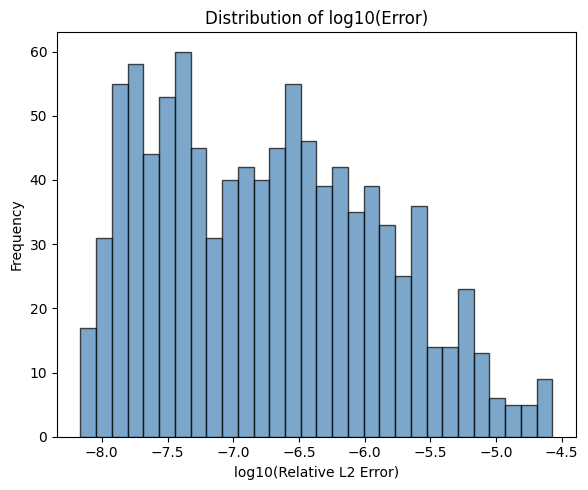

GeometricMean= 1.85e-07
IQR          = [3.49e-08, 7.78e-07]


In [33]:
set_seed(42)
K = 5
N = 1000
Errors = []
for i in range(N):
    mu, sigma, c = generate_random_function(K, mu_range=[-0.5, 0.5], sigma_range=[0.2, 1.0])
    f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
    f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
    f_body = torch.tensor(f_body)
    f_bdry = torch.tensor(f_bdry)
    rhs = torch.cat((f_body, f_bdry), dim=0)
    rhs_np = rhs.cpu().detach().numpy()
    w, _, _, _ = lstsq(A_np, rhs_np)
    perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)
    
    n_plot = 100  # 画图用 50x50 采样点
    x = np.linspace(-1, 1, n_plot)
    y = np.linspace(-1, 1, n_plot)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
    grid_points_torch = torch.from_numpy(grid_points)

    # 计算真实解 & 预测解
    Exact_u = torch.tensor(uj(grid_points, c, mu, sigma)).reshape(n_plot, n_plot).to(device)
    Train_u = perdict(grid_points_torch.to(device))
    Train_u = Train_u.reshape(n_plot, n_plot)
    Error = torch.abs(Exact_u - Train_u)
    Exact_u = Exact_u.detach().cpu().numpy()
    Train_u = Train_u.detach().cpu().numpy()
    Error = Error.detach().cpu().numpy()
    l2_error = np.sqrt(np.mean(Error**2))
    l2_error_rel = l2_error / np.sqrt(np.mean(Exact_u**2))
    Errors.append(l2_error_rel)
log_Errors = np.log10(Errors)

plt.figure(figsize=(6,5))
plt.hist(log_Errors, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel("log10(Relative L2 Error)")
plt.ylabel("Frequency")
plt.title("Distribution of log10(Error)")
plt.tight_layout()
plt.show()

geom_mean = 10**(np.mean(log_Errors))  
q25, q75 = np.percentile(Errors, [25, 75])

print(f"GeometricMean= {geom_mean:.2e}")
print(f"IQR          = [{q25:.2e}, {q75:.2e}]")

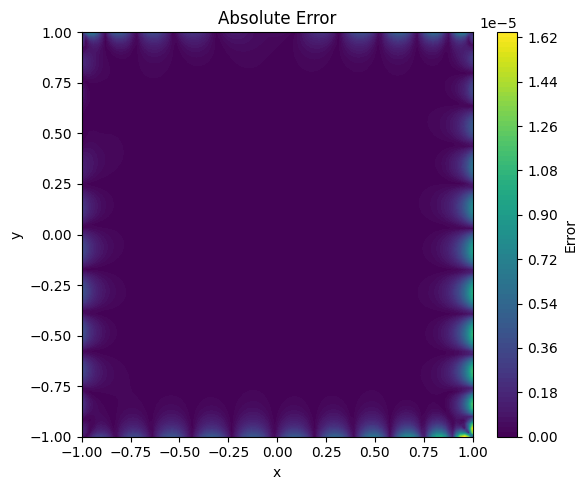

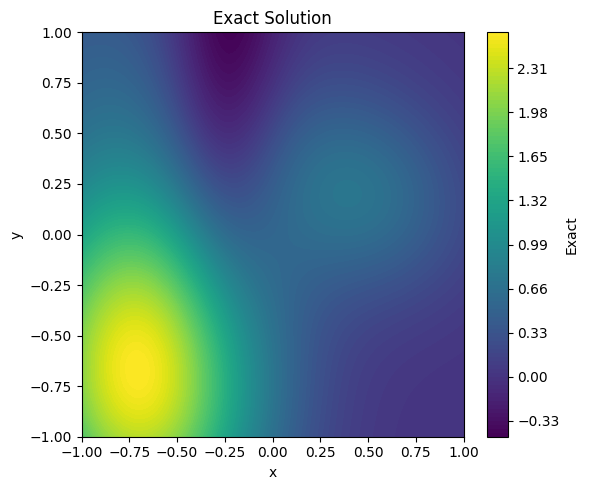

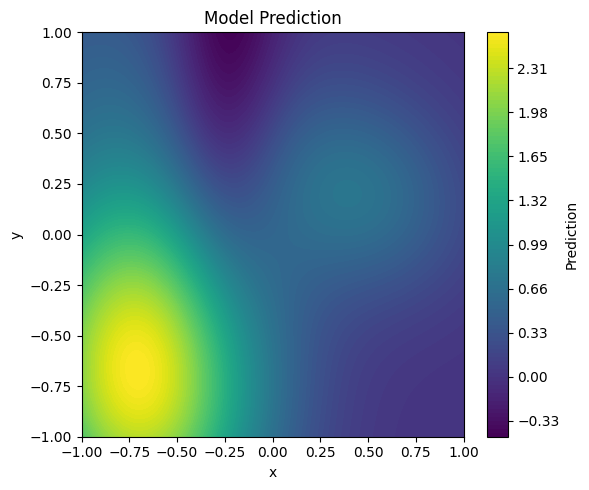

In [34]:
set_seed(42)
K = 5
N = 1
mu, sigma, c = generate_random_function(K, mu_range=[-1, 1], sigma_range=[0.2, 1.0])
f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
f_body = torch.tensor(f_body)
f_bdry = torch.tensor(f_bdry)
rhs = torch.cat((f_body, f_bdry), dim=0)
rhs_np = rhs.cpu().detach().numpy()
w, _, _, _ = lstsq(A_np, rhs_np)
perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)

n_plot = 100  # 画图用 50x50 采样点
x = np.linspace(-1, 1, n_plot)
y = np.linspace(-1, 1, n_plot)
xx, yy = np.meshgrid(x, y, indexing='ij')
grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
grid_points_torch = torch.from_numpy(grid_points)

# 计算真实解 & 预测解
Exact_u = torch.tensor(uj(grid_points, c, mu, sigma)).reshape(n_plot, n_plot).to(device)
Train_u = perdict(grid_points_torch.to(device))
Train_u = Train_u.reshape(n_plot, n_plot)
Error = torch.abs(Exact_u - Train_u)
Exact_u = Exact_u.detach().cpu().numpy()
Train_u = Train_u.detach().cpu().numpy()
Error = Error.detach().cpu().numpy()

plt.figure(figsize=(6, 5))
contour1 = plt.contourf(xx, yy, Error, levels=100, cmap="viridis")
plt.colorbar(contour1, label="Error")
plt.title("Absolute Error")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# === 第二张图：Exact Solution ===
plt.figure(figsize=(6, 5))
contour2 = plt.contourf(xx, yy, Exact_u, levels=100, cmap="viridis")
plt.colorbar(contour2, label="Exact")
plt.title("Exact Solution")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# === 第三张图：Model Prediction ===
plt.figure(figsize=(6, 5))
contour3 = plt.contourf(xx, yy, Train_u, levels=100, cmap="viridis")
plt.colorbar(contour3, label="Prediction")
plt.title("Model Prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

### Transfer to Annulus Domain

In [35]:
Pro = problem.PoissonAnnulus(f, u_exact, u_exact,bdry_penalty=0, device=device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "uniform")
body = Pro.data()["interior_points"]
bdry = Pro.data()["boundary_points"]

basis = lambda x: model(x)[0]
u_body = basis(body)
Nb, Mb = u_body.shape[0], u_body.shape[1]
A_body = torch.zeros(Nb, Mb, device=device)
for i in range(Mb):
    laplace = model.laplacian(body, i)  
    A_body[:, i] = (-laplace).detach()
A_bdry = basis(bdry)
A = torch.cat((A_body, A_bdry), dim=0)
A_np = A.cpu().detach().numpy()

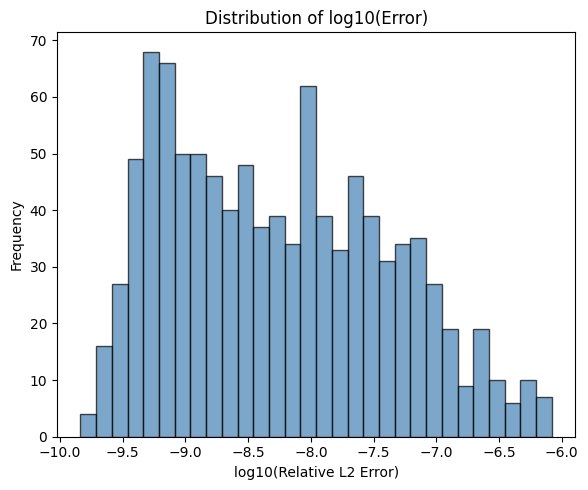

GeometricMean= 5.50e-09
IQR          = [8.93e-10, 2.52e-08]


In [36]:
K = 5
N = 1000
Errors_Annulus = []
for i in range(N):
    mu, sigma, c = generate_random_function(K, mu_range=[-0.5, 0.5], sigma_range=[0.2, 1.0])
    f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
    f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
    f_body = torch.tensor(f_body)
    f_bdry = torch.tensor(f_bdry)
    rhs = torch.cat((f_body, f_bdry), dim=0)
    rhs_np = rhs.cpu().detach().numpy()
    w, _, _, _ = lstsq(A_np, rhs_np)
    perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)
    
    n_plot = 100  # 画图用 50x50 采样点
    x = np.linspace(-1, 1, n_plot)
    y = np.linspace(-1, 1, n_plot)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
    grid_points_torch = torch.from_numpy(grid_points)
    r = np.sqrt(grid_points[:, 0] ** 2 + grid_points[:, 1] ** 2)
    mask = (r >= 0.5) & (r <= 1)  # 只保留在环形区域内的点
    valid_points = grid_points[mask]
    valid_points_torch = torch.tensor(valid_points)

    # 计算真实解 & 预测解
    Exact_u = torch.tensor(uj(valid_points, c, mu, sigma)).to(device)
    Train_u = perdict(valid_points_torch.to(device))
    Error = torch.abs(Exact_u - Train_u)
    Exact_u = Exact_u.detach().cpu().numpy()
    Train_u = Train_u.detach().cpu().numpy()
    Error = Error.detach().cpu().numpy()
    l2_error = np.sqrt(np.nanmean(Error**2))
    l2_error_rel = l2_error / np.sqrt(np.mean(Exact_u**2))
    Errors_Annulus.append(l2_error_rel)

log_Errors_Annulus = np.log10(Errors_Annulus)
plt.figure(figsize=(6,5))
plt.hist(log_Errors_Annulus, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel("log10(Relative L2 Error)")
plt.ylabel("Frequency")
plt.title("Distribution of log10(Error)")
plt.tight_layout()
plt.show()

geom_mean = 10**(np.mean(log_Errors_Annulus))  
q25, q75 = np.percentile(Errors_Annulus, [25, 75])

print(f"GeometricMean= {geom_mean:.2e}")
print(f"IQR          = [{q25:.2e}, {q75:.2e}]")

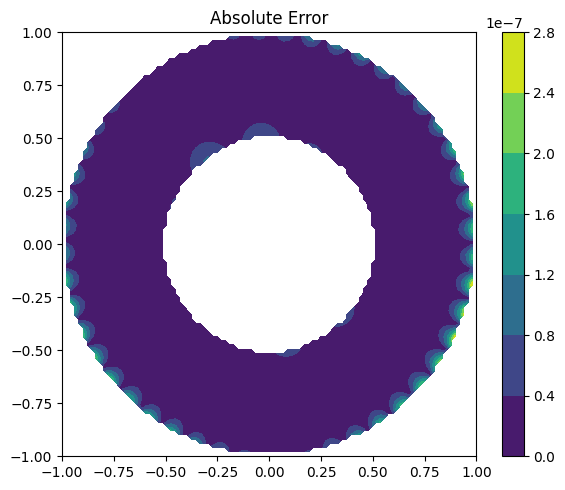

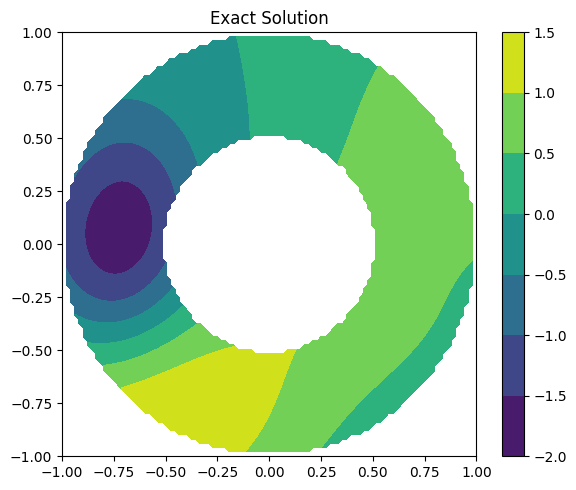

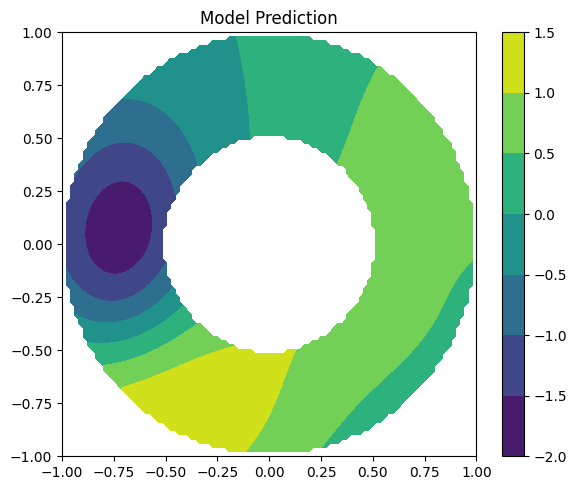

In [37]:
K = 5
N = 1
mu, sigma, c = generate_random_function(K)
f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
f_body = torch.tensor(f_body)
f_bdry = torch.tensor(f_bdry)
rhs = torch.cat((f_body, f_bdry), dim=0)
rhs_np = rhs.cpu().detach().numpy()
w, _, _, _ = lstsq(A_np, rhs_np)
perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)

n_plot = 100  # 画图用 100x100 采样点
R_out = 1
R_in = 0.5
x = np.linspace(-R_out, R_out, n_plot)
y = np.linspace(-R_out, R_out, n_plot)
xx, yy = np.meshgrid(x, y, indexing='ij')
grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
grid_points_torch = torch.from_numpy(grid_points).to(device)

# **去掉环形外的点**
r = np.sqrt(grid_points[:, 0] ** 2 + grid_points[:, 1] ** 2)
mask = (r >= R_in) & (r <= R_out)  # 只保留在环形区域内的点
valid_points = grid_points[mask]
valid_points_torch = torch.from_numpy(valid_points).to(device)

# 计算真实解 & 预测解
Exact_u = torch.tensor(uj(valid_points, c, mu, sigma)).to(device)
Train_u = perdict(valid_points_torch).view(-1)
Error = torch.abs(Exact_u - Train_u)

# **填充到完整网格**
Exact_u_full = torch.full((n_plot * n_plot,), float("nan"), device=device)
Train_u_full = torch.full((n_plot * n_plot,), float("nan"), device=device)
Error_full = torch.full((n_plot * n_plot,), float("nan"), device=device)

Exact_u_full[mask] = Exact_u
Train_u_full[mask] = Train_u
Error_full[mask] = Error

Exact_u_full = Exact_u_full.reshape(n_plot, n_plot).detach().cpu().numpy()
Train_u_full = Train_u_full.reshape(n_plot, n_plot).detach().cpu().numpy()
Error_full = Error_full.reshape(n_plot, n_plot).detach().cpu().numpy()

l2_error = np.sqrt(np.nanmean(Error_full**2))
l2_error_rel = l2_error / np.sqrt(np.nanmean(Exact_u_full**2))

fig1 = plt.figure(figsize=(6, 5))
ax1 = fig1.add_subplot(111)
cf1 = ax1.contourf(xx, yy, Error_full)
ax1.set_title("Absolute Error")
plt.colorbar(cf1, ax=ax1)
plt.tight_layout()
plt.show()

# === 第二张图：Exact Solution ===
fig2 = plt.figure(figsize=(6, 5))
ax2 = fig2.add_subplot(111)
cf2 = ax2.contourf(xx, yy, Exact_u_full)
ax2.set_title("Exact Solution")
plt.colorbar(cf2, ax=ax2)
plt.tight_layout()
plt.show()

# === 第三张图：Model Prediction ===
fig3 = plt.figure(figsize=(6, 5))
ax3 = fig3.add_subplot(111)
cf3 = ax3.contourf(xx, yy, Train_u_full)
ax3.set_title("Model Prediction")
plt.colorbar(cf3, ax=ax3)
plt.tight_layout()
plt.show()

### Transfer to L-shape Domain

In [38]:
Pro = problem.PoissonL(f, u_exact, u_exact,bdry_penalty=0, device=device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "uniform")
body = Pro.data()["interior_points"]
bdry = Pro.data()["boundary_points"]

basis = lambda x: model(x)[0]
u_body = basis(body)
Nb, Mb = u_body.shape[0], u_body.shape[1]
A_body = torch.zeros(Nb, Mb, device=device)
for i in range(Mb):
    laplace = model.laplacian(body, i)  
    A_body[:, i] = (-laplace).detach()
A_bdry = basis(bdry)
A = torch.cat((A_body, A_bdry), dim=0)
A_np = A.cpu().detach().numpy()

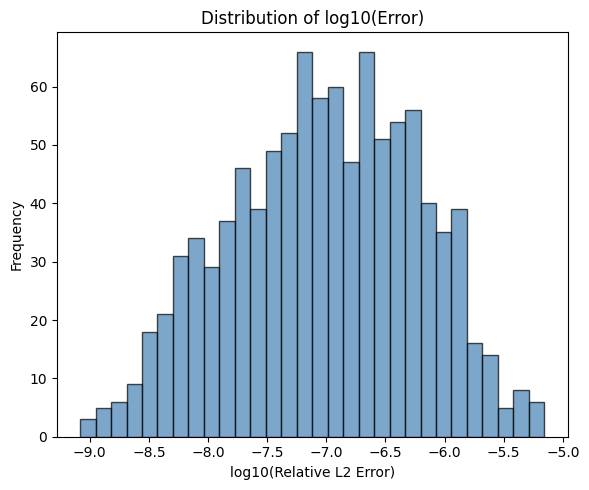

GeometricMean= 9.50e-08
IQR          = [2.41e-08, 4.03e-07]


In [39]:
set_seed(42)
K = 5
N = 1000
Errors_L = []
for i in range(N):
    mu, sigma, c = generate_random_function(K)
    f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
    f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
    f_body = torch.tensor(f_body)
    f_bdry = torch.tensor(f_bdry)
    rhs = torch.cat((f_body, f_bdry), dim=0)
    rhs_np = rhs.cpu().detach().numpy()
    w, _, _, _ = lstsq(A_np, rhs_np)
    perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)
    
    n_plot = 100  # 画图用 50x50 采样点
    x = np.linspace(-1, 1, n_plot)
    y = np.linspace(-1, 1, n_plot)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
    grid_points_torch = torch.from_numpy(grid_points)
    mask = ~((grid_points[:, 0] >= 0) & (grid_points[:, 1] >= 0))
    valid_points = grid_points[mask]
    valid_points_torch = torch.tensor(valid_points)

    # 计算真实解 & 预测解
    Exact_u = torch.tensor(uj(valid_points, c, mu, sigma)).to(device)
    Train_u = perdict(valid_points_torch.to(device))
    Error = torch.abs(Exact_u - Train_u)
    Exact_u = Exact_u.detach().cpu().numpy()
    Train_u = Train_u.detach().cpu().numpy()
    Error = Error.detach().cpu().numpy()
    l2_error = np.sqrt(np.nanmean(Error**2))
    l2_error_rel = l2_error / np.sqrt(np.mean(Exact_u**2))
    Errors_L.append(l2_error_rel)

log_Errors_L = np.log10(Errors_L)

plt.figure(figsize=(6,5))
plt.hist(log_Errors_L, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel("log10(Relative L2 Error)")
plt.ylabel("Frequency")
plt.title("Distribution of log10(Error)")
plt.tight_layout()
plt.show()

geom_mean = 10**(np.mean(log_Errors_L))  
q25, q75 = np.percentile(Errors_L, [25, 75])

print(f"GeometricMean= {geom_mean:.2e}")
print(f"IQR          = [{q25:.2e}, {q75:.2e}]")

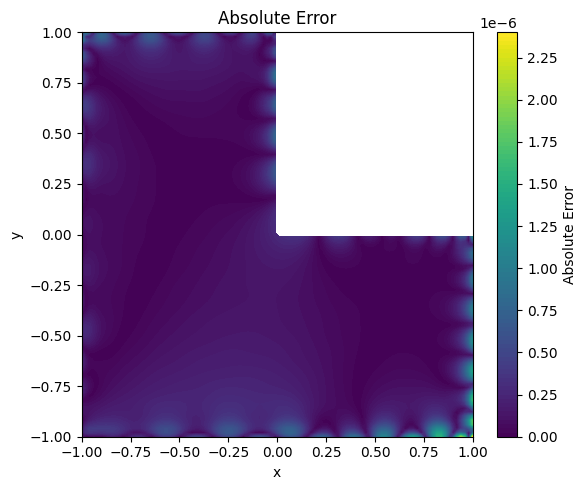

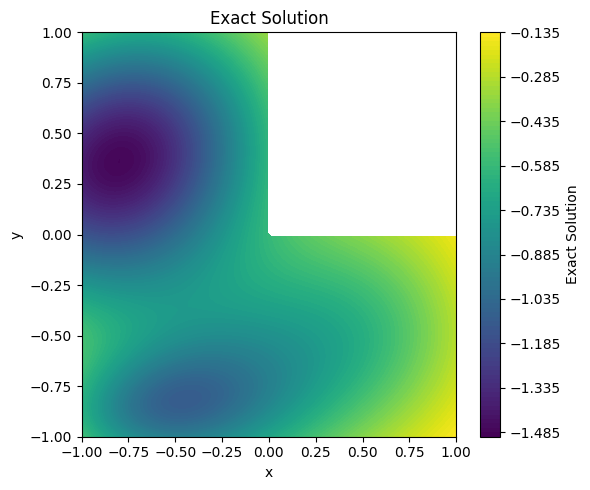

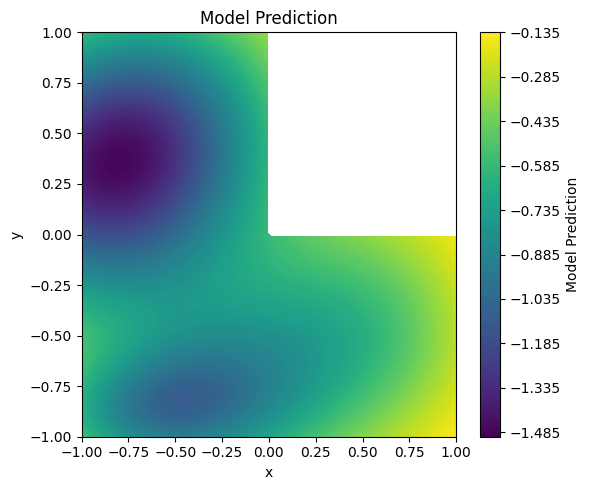

In [40]:
set_seed(42)
K = 5
N = 1
mu, sigma, c = generate_random_function(K, mu_range=[-0.5, 0.5], sigma_range=[0.2, 1.0])
mu, sigma, c = generate_random_function(K)
f_body = laplacian_uj(body.detach().cpu().numpy(), c, mu, sigma)
f_bdry = uj(bdry.detach().cpu().numpy(), c, mu, sigma)
f_body = torch.tensor(f_body)
f_bdry = torch.tensor(f_bdry)
rhs = torch.cat((f_body, f_bdry), dim=0)
rhs_np = rhs.cpu().detach().numpy()
w, _, _, _ = lstsq(A_np, rhs_np)
perdict = lambda x: model(x)[0] @ torch.tensor(w, device=device)

n_plot = 100  # 画图用 100x100 采样点
R_out = 1
R_in = 1
x = np.linspace(-R_out, R_out, n_plot)
y = np.linspace(-R_out, R_out, n_plot)
xx, yy = np.meshgrid(x, y, indexing='ij')
grid_points = np.stack([xx.flatten(), yy.flatten()], axis=-1)
grid_points_torch = torch.from_numpy(grid_points).to(device)

# **去掉环形外的点**
mask = ~((grid_points[:, 0] >= 0) & (grid_points[:, 1] >= 0))
valid_points = grid_points[mask]
valid_points_torch = torch.from_numpy(valid_points).to(device)

# 计算真实解 & 预测解
Exact_u = torch.tensor(uj(valid_points_torch.detach().cpu().numpy(), c, mu, sigma)).to(device)
Train_u = perdict(valid_points_torch ).view(-1)
Error = torch.abs(Exact_u - Train_u)

# **填充到完整网格**
Exact_u_full = torch.full((n_plot * n_plot,), float("nan"), device=device)
Train_u_full = torch.full((n_plot * n_plot,), float("nan"), device=device)
Error_full = torch.full((n_plot * n_plot,), float("nan"), device=device)

Exact_u_full[mask] = Exact_u
Train_u_full[mask] = Train_u
Error_full[mask] = Error

Exact_u_full = Exact_u_full.reshape(n_plot, n_plot).detach().cpu().numpy()
Train_u_full = Train_u_full.reshape(n_plot, n_plot).detach().cpu().numpy()
Error_full = Error_full.reshape(n_plot, n_plot).detach().cpu().numpy()

l2_error = np.sqrt(np.nanmean(Error_full**2))
l2_error_rel = l2_error / np.sqrt(np.nanmean(Exact_u_full**2))

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
cf = ax.contourf(xx, yy, Error_full, levels=100, cmap="viridis")
cbar = plt.colorbar(cf, ax=ax)
cbar.set_label("Absolute Error")
ax.set_title("Absolute Error")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()
plt.show()

# === 第二张图：Exact Solution (2D) ===
fig2 = plt.figure(figsize=(6, 5))
ax2 = fig2.add_subplot(111)
cf2 = ax2.contourf(xx, yy, Exact_u_full, levels=100, cmap="viridis")
cbar2 = plt.colorbar(cf2, ax=ax2)
cbar2.set_label("Exact Solution")
ax2.set_title("Exact Solution")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
plt.tight_layout()
plt.show()

# === 第三张图：Model Prediction (2D) ===
fig3 = plt.figure(figsize=(6, 5))
ax3 = fig3.add_subplot(111)
cf3 = ax3.contourf(xx, yy, Train_u_full, levels=100, cmap="viridis")
cbar3 = plt.colorbar(cf3, ax=ax3)
cbar3.set_label("Model Prediction")
ax3.set_title("Model Prediction")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.tight_layout()
plt.show()